In [61]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from plotnine import ggplot, aes, geom_line, scale_x_date, labs, ggtitle

In [2]:
#load in the data
equity_etf = pd.read_csv('Data/IVV.csv')
gold_etf = pd.read_csv('Data/GLD.csv')
bitcoin = pd.read_csv('Data/BTC-USD.csv')
#Convert the data into the datetime format and make it the index to query the dataframe easier.
gold_etf["Date"] = pd.to_datetime(gold_etf["Date"], format="%Y-%m-%d")
gold_etf.set_index("Date", inplace=True)
equity_etf["Date"] = pd.to_datetime(equity_etf["Date"], format="%Y-%m-%d")
equity_etf.set_index("Date", inplace=True)
bitcoin["Date"] = pd.to_datetime(bitcoin["Date"], format="%Y-%m-%d")
bitcoin.set_index("Date", inplace=True)

In [12]:
gold_returns = 100 * gold_etf['Adj Close'].pct_change().dropna()
equity_returns = 100 * equity_etf['Adj Close'].pct_change().dropna()
bitcoin_returns = 100 *bitcoin['Adj Close'].pct_change().dropna()

<AxesSubplot:xlabel='Date'>

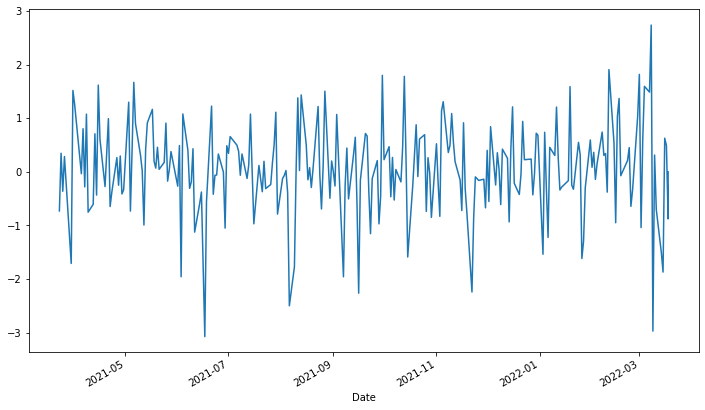

In [13]:
gold_returns.plot(figsize=(12,7))

<AxesSubplot:xlabel='Date'>

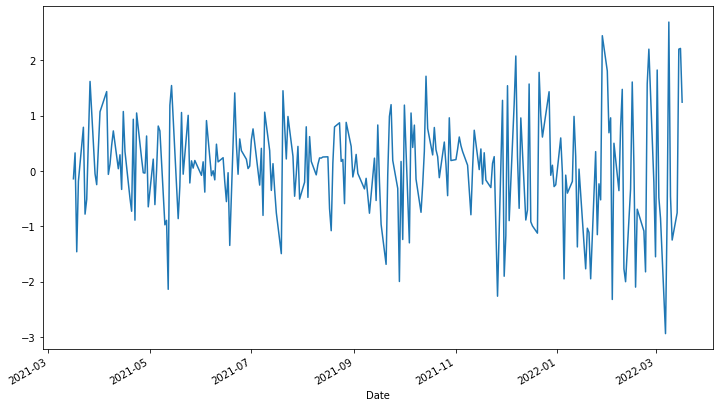

In [14]:
equity_returns.plot(figsize=(12,7))

<AxesSubplot:xlabel='Date'>

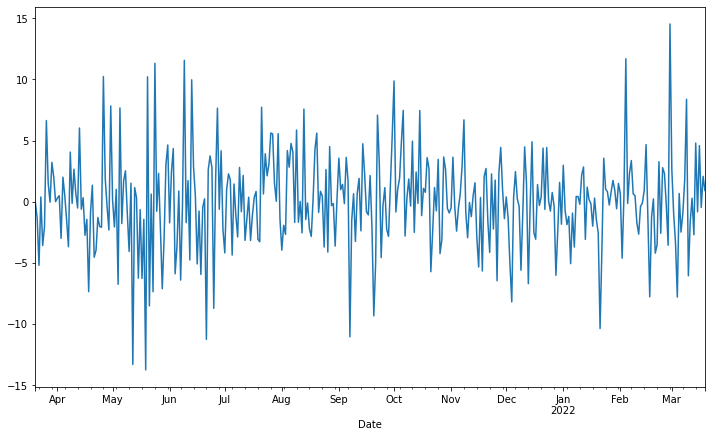

In [15]:
bitcoin_returns.plot(figsize=(12,7))

# All the series show seasonality, so we difference once more

In [20]:
gold_returns = gold_returns.diff().dropna()
equity_returns = equity_returns.diff().dropna()
bitcoin_returns = bitcoin_returns.diff().dropna()

<AxesSubplot:xlabel='Date'>

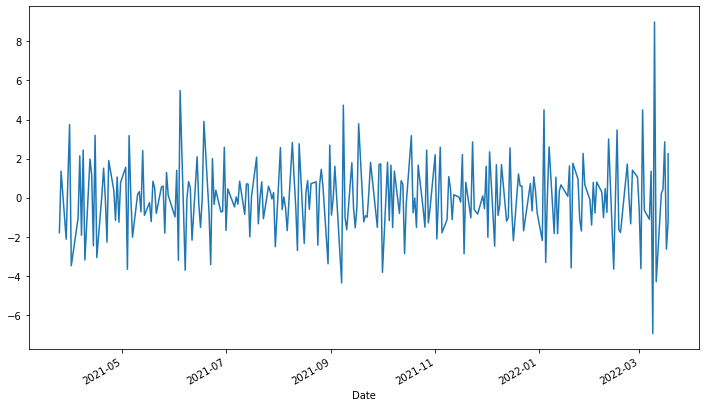

In [21]:
gold_returns.plot(figsize=(12,7))

<AxesSubplot:xlabel='Date'>

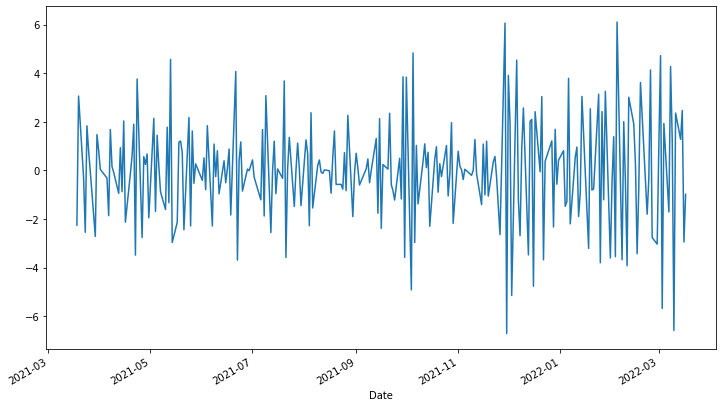

In [22]:
equity_returns.plot(figsize=(12,7))

<AxesSubplot:xlabel='Date'>

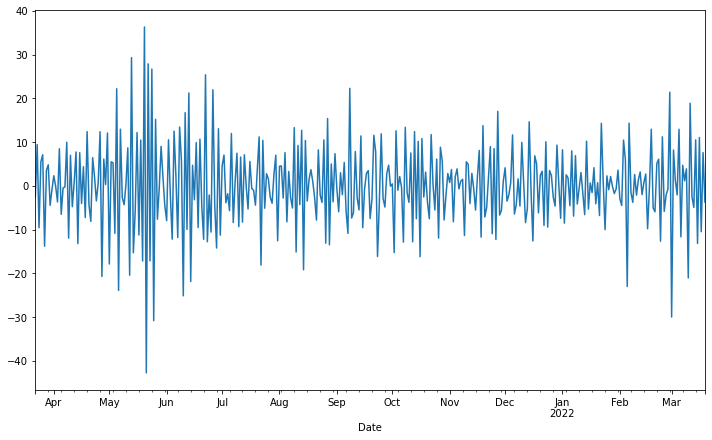

In [23]:
bitcoin_returns.plot(figsize=(12,7))

# 

Select the best GARCH parameters by using AIC and BIC

In [24]:
from arch import arch_model

def select_params(data):
  # loop over AR term
  for p in range(1, 4):
    # loop over MA term
    for q in range(1, 4):
      model = arch_model(data, vol="GARCH", p=p, q=q)
      results = model.fit(update_freq=5, disp="off")
      print(p, q, results.aic, results.bic)

In [25]:
select_params(gold_returns)

1 1 1022.8883905312555 1036.9742342027046
1 2 1024.88839052101 1042.4956951103213
1 3 1024.2561807119118 1045.3849462190854
2 1 1024.8883907170355 1042.4956953063468
2 2 1026.888391429662 1048.0171569368356
2 3 1026.2561806636836 1050.9064070887193
3 1 1026.8883905381715 1048.017156045345
3 2 1028.888391087828 1053.5386175128638
3 3 1028.2561806206577 1056.4278679635556


In [26]:
select_params(equity_returns)

1 1 1050.7003641167098 1064.8339220716198
1 2 1048.4019473354292 1066.0688947790668
1 3 1047.2682878326927 1068.468624765058
2 1 1052.7003641101687 1070.3673115538063
2 2 1050.401947320194 1071.6022842525592
2 3 1049.2682877352072 1074.0020141562998
3 1 1052.7049729319388 1073.905309864304
3 2 1052.4019473660778 1077.1356737871704
3 3 1051.2682879309057 1079.5354038407258


In [27]:
select_params(bitcoin_returns)

1 1 2615.752761704749 2631.3303730418083
1 2 2617.7102321709626 2637.182246342287
1 3 2617.6894742532118 2641.055891258801
2 1 2617.7527615559543 2637.2247757272785
2 2 2619.710232554835 2643.076649560424
2 3 2619.689474458273 2646.9502942981267
3 1 2619.7140235945335 2643.0804406001225
3 2 2621.7102321557522 2648.971051995606
3 3 2621.6894741850797 2652.8446968591984


The data shows that a GARCH (1,1) model is the best fit.

In [28]:
import pmdarima as pmd
import arch

def arma_garch(data):
  # fit ARIMA on returns 
  arima_model= pmd.auto_arima(data, start_p=1, start_q=1, test="adf", trace=True)
  #p, d, q = arima_model.order
  #print("ARIMA order:", p, d, q)
  arima_residuals = arima_model.arima_res_.resid
  # fit a GARCH(1,1) model on the residuals of the ARIMA model
  garch_model = arch.arch_model(arima_residuals, mean="constant", vol="GARCH", p=1, q=1)
  garch_fitted = garch_model.fit(update_freq=5, disp="off")
  print(garch_fitted)

In [29]:
arma_garch(gold_returns)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1044.836, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=951.717, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1042.836, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=868.652, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=824.256, Time=0.22 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=783.199, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=772.135, Time=0.44 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=770.143, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=781.206, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=1.14 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.78 sec

Bes

In [30]:
arma_garch(equity_returns)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1103.392, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=990.784, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1101.393, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=932.470, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=892.391, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=854.553, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=829.405, Time=0.26 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=827.418, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=852.569, Time=0.13 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.97 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.71 sec

Bes

In [31]:
arma_garch(bitcoin_returns)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2691.005, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2473.066, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2689.005, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2383.514, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2292.427, Time=0.33 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=2251.015, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=2220.632, Time=0.49 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=2218.632, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=2249.015, Time=0.19 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=1.26 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=1.01 s

# Exponential GARCH

In [32]:
def egarch_model(data):
  # fit ARIMA on returns 
  arima_model= pmd.auto_arima(data, start_p=1, start_q=1, test="adf", trace=True)
  #p, d, q = arima_model.order
  #print("ARIMA order:", p, d, q)
  arima_residuals = arima_model.arima_res_.resid
  # fit a GARCH(1,1) model on the residuals of the ARIMA model
  egarch_model = arch.arch_model(arima_residuals, mean="constant", vol="EGARCH", p=1, q=1)
  egarch_fitted = egarch_model.fit(update_freq=5, disp="off")
  print(egarch_fitted)

In [33]:
egarch_model(gold_returns)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1044.836, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=951.717, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1042.836, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=868.652, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=824.256, Time=0.22 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=783.199, Time=0.19 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=772.135, Time=0.26 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=770.143, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=781.206, Time=0.13 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=1.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.84 sec

Bes

And the variance of the covariance-stationary (unconditional variance) process is given by:
𝜔/(1−𝛼−𝛽)

The long-run variance, also known as the unconditional variance is given by the second equation and applying it to the models that satisfy the covariance-stationary process yields:

In [36]:
def unconditional_variance(omega, alpha, beta):
  try:
    value = omega/(1-alpha-beta)
    print("Unconditional variance is:", value)
  except:
    print('Persistency in volatility. IGARCH model should be used')

In [39]:
# ARMA-GARCH for gold returns
import math

w = 0.1323
a = 0.0535
b = 0.8377
print('ARMA-GARCH for gold returns')
unconditional_variance(w, a, b)

ARMA-GARCH for gold returns
Unconditional variance is: 1.2159926470588234


In [40]:
# ARMA-GARCH for equity returns
w = 0.1028
a = 0.2094
b = 0.7363
print('ARMA-GARCH for equity returns')
unconditional_variance(w, a, b)

ARMA-GARCH for equity returns
Unconditional variance is: 1.8931860036832409


In [41]:
# ARMA-GARCH for bitcoin returns
w = 1.0298
a = 0.0470
b = 0.9133
print('ARMA-GARCH for bitcoin returns')
unconditional_variance(w, a, b)

ARMA-GARCH for bitcoin returns
Unconditional variance is: 25.93954659949625


In [43]:
# ARMA-EGARCH for gold returns
w = 0.0271
a = 0.0994
b = 0.8640
print('ARMA-EGARCH for gold returns')
unconditional_variance(w, a, b)

ARMA-EGARCH for gold returns
Unconditional variance is: 0.7404371584699461


In [42]:
# ARMA-EGARCH for equity returns
w = 0.0388
a = 0.4071
b = 0.8974
print('ARMA-EGARCH for equity returns')
unconditional_variance(w, a, b)

ARMA-EGARCH for equity returns
Unconditional variance is: -0.12742200328407224


In [44]:
# ARMA-EGARCH for bitcoin returns
w = 0.1592
a = 0.1034
b = 0.9509
print('ARMA-EGARCH for bitcoin returns')
unconditional_variance(w, a, b)

ARMA-EGARCH for bitcoin returns
Unconditional variance is: -2.9318600368324117


# Forecasting Returns

In [74]:
from plotnine import geom_point, ggplot, aes, geom_line, xlab, ylab, ggtitle, geom_point, theme, element_text

In [130]:
from statsmodels.tsa.arima.model import ARIMA

results_ARMA_bitcoin =pd.DataFrame()

for index, values in pd.DataFrame(bitcoin_returns).loc['2021-12-30':'2022-03-15'].iterrows():
  model = ARIMA(bitcoin_returns[index - pd.Timedelta(days=30):index], order=(1,0,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  df_forecast = pd.DataFrame(output)
  df_forecast.columns = ['Bitcoin Forecast']
  results_ARMA_bitcoin = pd.concat([results_ARMA_bitcoin,df_forecast])

results_ARMA_bitcoin.index = pd.DataFrame(bitcoin_returns).loc['2021-12-30':'2022-03-15'].index
print(results_ARMA_bitcoin.head())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was pro

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

            Bitcoin Forecast
Date                        
2021-12-30         -4.064800
2021-12-31          4.099004
2022-01-01         -5.489427
2022-01-02          4.697176
2022-01-03          1.129982


In [131]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model_fit.resid)

2.3545917078439595

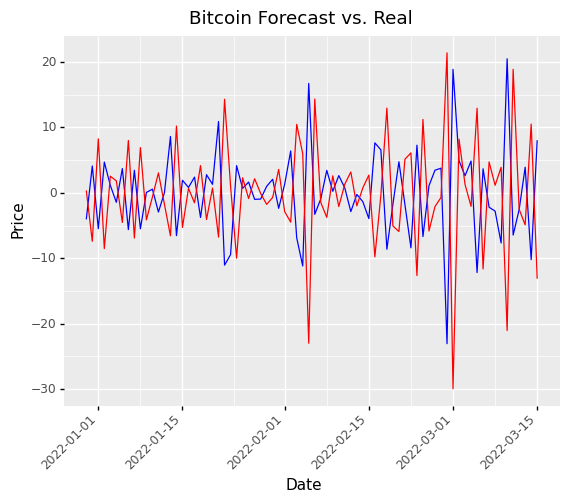

In [132]:
data_ARMA = pd.concat([bitcoin_returns['2021-12-30':'2022-03-15':].reindex(method="pad").rename('Bitcoin Returns'),
                            results_ARMA_bitcoin['Bitcoin Forecast']],axis=1, join="inner")
print(ggplot(data_ARMA,aes(x='data_ARMA.index')) + geom_line(aes(y='Bitcoin Forecast'),color='blue') + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Bitcoin Returns'),color='red') + ggtitle('Bitcoin Forecast vs. Real ')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

In [140]:
results_ARMA_gold=pd.DataFrame()

for index, values in pd.DataFrame(gold_returns).loc['2021-12-30':'2022-03-15'].iterrows():
  model = ARIMA(gold_returns[index - pd.Timedelta(days=30):index], order=(1,0,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  df_forecast = pd.DataFrame(output)
  df_forecast.columns = ['Gold Forecast']
  results_ARMA_gold = pd.concat([results_ARMA_gold,df_forecast])

results_ARMA_gold.index = pd.DataFrame(gold_returns).loc['2021-12-30':'2022-03-15'].index
print(results_ARMA_gold.head())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be g

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provid

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but

            Gold Forecast
Date                     
2021-12-30      -0.986821
2021-12-31       0.154509
2022-01-03       2.486929
2022-01-04      -3.481034
2022-01-05       1.503075


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


In [141]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model_fit.resid)

1.9790760011597484

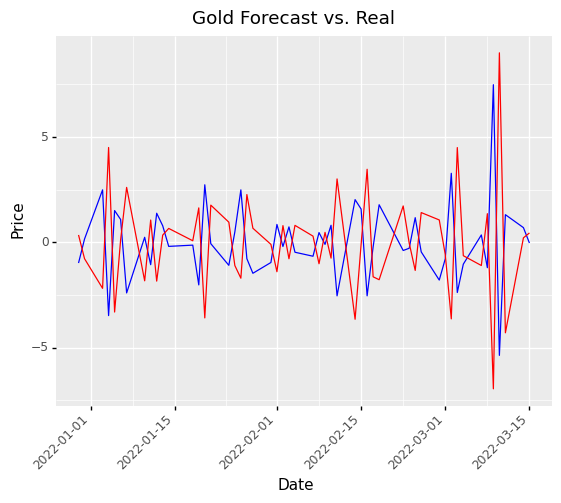

In [142]:
data_ARMA = pd.concat([gold_returns['2021-12-30':'2022-03-15':].reindex(method="pad").rename('Gold Returns'),
                            results_ARMA_gold['Gold Forecast']],axis=1, join="inner")
print(ggplot(data_ARMA,aes(x='data_ARMA.index')) + geom_line(aes(y='Gold Forecast'),color='blue') + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Gold Returns'),color='red') + ggtitle('Gold Forecast vs. Real ')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

In [139]:
results_ARMA_equity=pd.DataFrame()

for index, values in pd.DataFrame(equity_returns).loc['2021-12-30':'2022-03-15'].iterrows():
  model = ARIMA(equity_returns[index - pd.Timedelta(days=30):index], order=(1,0,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  df_forecast = pd.DataFrame(output)
  df_forecast.columns = ['Equity Forecast']
  results_ARMA_equity = pd.concat([results_ARMA_equity,df_forecast])

results_ARMA_equity.index = pd.DataFrame(equity_returns).loc['2021-12-30':'2022-03-15'].index
print(results_ARMA_equity.head())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

            Equity Forecast
Date                       
2021-12-30         0.318865
2021-12-31        -0.128662
2022-01-03        -1.046366
2022-01-04         0.932600
2022-01-05         2.284661


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

In [143]:
durbin_watson(model_fit.resid)

1.9790760011597484

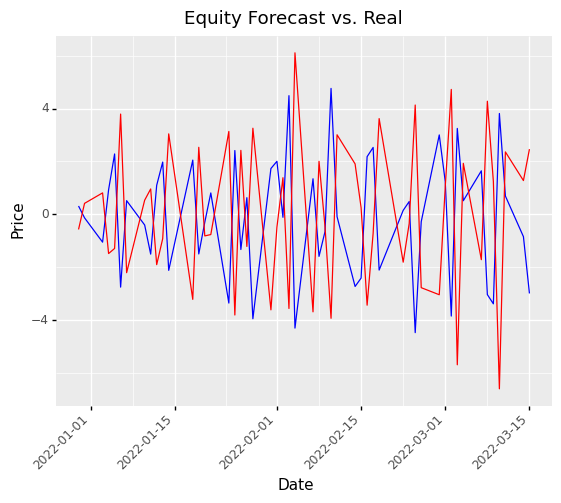

In [144]:
data_ARMA = pd.concat([equity_returns['2021-12-30':'2022-03-15':].reindex(method="pad").rename('Equity Returns'),
                            results_ARMA_equity['Equity Forecast']],axis=1, join="inner")
print(ggplot(data_ARMA,aes(x='data_ARMA.index')) + geom_line(aes(y='Equity Forecast'),color='blue') + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Equity Returns'),color='red') + ggtitle('Equity Forecast vs. Real ')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

In [146]:
from arch import arch_model
#import pmdarima as pmd

results_ARMA_GARCH_gold=pd.DataFrame()

for index, values in pd.DataFrame(gold_returns).loc['2021-12-30':'2022-03-15'].iterrows():
  
  model = ARIMA(gold_returns[index - pd.Timedelta(days=30):index], order=(1,1,0))
  model_fit = model.fit()
  arima_residuals = model_fit.resid
  
  garch_model = arch_model(arima_residuals, mean="zero", vol="GARCH", p=1,q=1)
  garch_fit = garch_model.fit(update_freq=5, disp="off")

  mu_pred = model_fit.forecast()
  et_pred = garch_fit.forecast(horizon=1).mean['h.1'].iloc[-1]
  next_return = mu_pred + et_pred
  
  df_forecast = pd.DataFrame(next_return)
  df_forecast.columns = ['Gold Forecast']
  results_ARMA_GARCH_gold = pd.concat([results_ARMA_GARCH_gold,df_forecast])

results_ARMA_GARCH_gold.index = pd.DataFrame(gold_returns).loc['2021-12-30':'2022-03-15'].index
print(results_ARMA_GARCH_gold.head())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

            Gold Forecast
Date                     
2021-12-30       0.858599
2021-12-31       0.018595
2022-01-03      -1.466690
2022-01-04       0.535015
2022-01-05       2.643379


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


In [147]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(garch_fit.resid, lags=[10,15,20], return_df = True)

,lb_stat,lb_pvalue
10,10.183941,0.424506
15,15.076445,0.445925
20,24.865998,0.206606


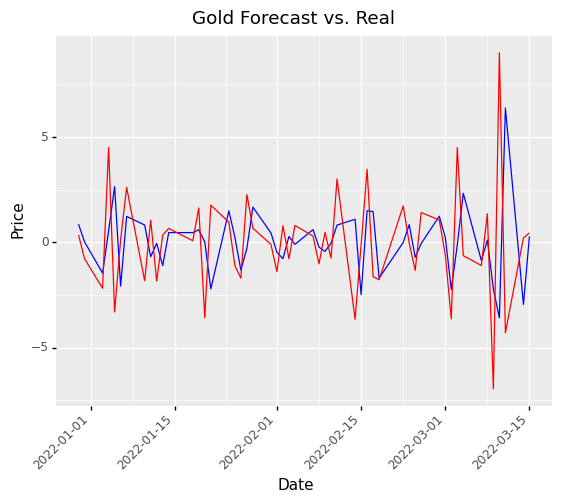

In [151]:
data_ARMA_GARCH = pd.concat([gold_returns['2021-12-30':'2022-03-15':].reindex(method="pad").rename('Gold Returns'),
                            results_ARMA_GARCH_gold['Gold Forecast']],axis=1, join="inner")
print(ggplot(data_ARMA_GARCH,aes(x='data_ARMA_GARCH.index')) + geom_line(aes(y='Gold Forecast'),color='blue') + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Gold Returns'),color='red') + ggtitle('Gold Forecast vs. Real ')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

In [150]:

results_ARMA_GARCH_equity=pd.DataFrame()

for index, values in pd.DataFrame(equity_returns).loc['2021-12-30':'2022-03-15'].iterrows():
  
  model = ARIMA(equity_returns[index - pd.Timedelta(days=30):index], order=(1,1,0))
  model_fit = model.fit()
  arima_residuals = model_fit.resid
  
  garch_model = arch_model(arima_residuals, mean="zero", vol="GARCH", p=1,q=1)
  garch_fit = garch_model.fit(update_freq=5, disp="off")

  mu_pred = model_fit.forecast()
  et_pred = garch_fit.forecast(horizon=1).mean['h.1'].iloc[-1]
  next_return = mu_pred + et_pred
  
  df_forecast = pd.DataFrame(next_return)
  df_forecast.columns = ['Equity Forecast']
  results_ARMA_GARCH_equity = pd.concat([results_ARMA_GARCH_equity,df_forecast])

results_ARMA_GARCH_equity.index = pd.DataFrame(equity_returns).loc['2021-12-30':'2022-03-15'].index
print(results_ARMA_GARCH_equity.head())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No fre

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

            Equity Forecast
Date                       
2021-12-30         0.836517
2021-12-31        -0.166063
2022-01-03         0.584400
2022-01-04        -0.139914
2022-01-05        -1.395933


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pr

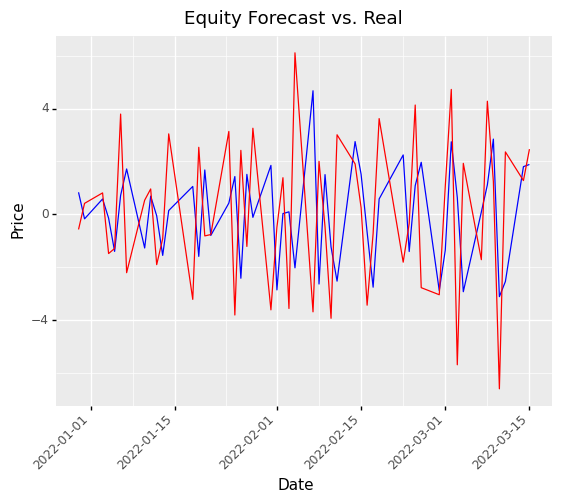

In [153]:
data_ARMA_GARCH = pd.concat([equity_returns['2021-12-30':'2022-03-15':].reindex(method="pad").rename('Equity Returns'),
                            results_ARMA_GARCH_equity['Equity Forecast']],axis=1, join="inner")
print(ggplot(data_ARMA_GARCH,aes(x='data_ARMA_GARCH.index')) + geom_line(aes(y='Equity Forecast'),color='blue') + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Equity Returns'),color='red') + ggtitle('Equity Forecast vs. Real ')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

In [154]:
results_ARMA_GARCH_bitcoin=pd.DataFrame()

for index, values in pd.DataFrame(bitcoin_returns).loc['2021-12-30':'2022-03-15'].iterrows():
  
  model = ARIMA(bitcoin_returns[index - pd.Timedelta(days=30):index], order=(1,1,0))
  model_fit = model.fit()
  arima_residuals = model_fit.resid
  
  garch_model = arch_model(arima_residuals, mean="zero", vol="GARCH", p=1,q=1)
  garch_fit = garch_model.fit(update_freq=5, disp="off")

  mu_pred = model_fit.forecast()
  et_pred = garch_fit.forecast(horizon=1).mean['h.1'].iloc[-1]
  next_return = mu_pred + et_pred
  
  df_forecast = pd.DataFrame(next_return)
  df_forecast.columns = ['Bitcoin Forecast']
  results_ARMA_GARCH_bitcoin = pd.concat([results_ARMA_GARCH_bitcoin,df_forecast])

results_ARMA_GARCH_bitcoin.index = pd.DataFrame(bitcoin_returns).loc['2021-12-30':'2022-03-15'].index
print(results_ARMA_GARCH_bitcoin.head())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, 

            Bitcoin Forecast
Date                        
2021-12-30          4.779321
2021-12-31         -3.790804
2022-01-01          0.632039
2022-01-02          0.241274
2022-01-03         -3.579838


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.


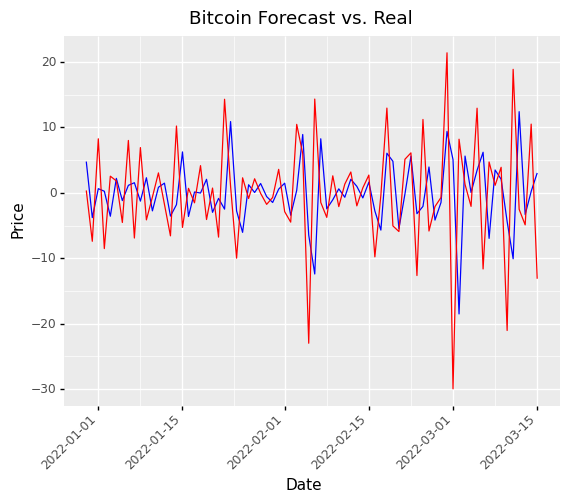

In [155]:
data_ARMA_GARCH = pd.concat([bitcoin_returns['2021-12-30':'2022-03-15':].reindex(method="pad").rename('Bitcoin Returns'),
                            results_ARMA_GARCH_bitcoin['Bitcoin Forecast']],axis=1, join="inner")
print(ggplot(data_ARMA_GARCH,aes(x='data_ARMA_GARCH.index')) + geom_line(aes(y='Bitcoin Forecast'),color='blue') + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Bitcoin Returns'),color='red') + ggtitle('Bitcoin Forecast vs. Real ')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

# Build 2 trading strategies that uses only the previous values of that series

# ** Next Day Forecast Strategy.
If forecast shows positive returns BUY. If negative SELL.
We assume we have the same amount of money invested each day.

In [172]:
best_outcome_equity = 0

for index,value in equity_returns['2021-07-25':].items():
  if value > 0:
    best_outcome_equity += value

total_ARMA = 0
forecast_ARMA = results_ARMA_equity > 0
for index, value in forecast_ARMA['Equity Forecast'].items():
  if (value):
    try:
      total_ARMA += equity_returns[index]
    except:
      print('No available returns for {}'.format(index))
print('ARMA outcome: {:.5f}. \nBest possible outcome: {:.5f}\n'.format(total_ARMA,best_outcome_equity))

total_ARMA_GARCH = 0
forecast_ARMA_GARCH = results_ARMA_GARCH_equity > 0

for index, value in forecast_ARMA_GARCH['Equity Forecast'].items():
  if (value):
    try:
      total_ARMA_GARCH += equity_returns[index]
    except:
      print('No available returns for {}'.format(index))
print('ARMA GARCH outcome: {:.5f}. \nBest possible outcome: {:.5f}\n'.format(total_ARMA_GARCH,best_outcome_equity))

ARMA outcome: -50.50409. 
Best possible outcome: 140.89217

ARMA GARCH outcome: 1.98491. 
Best possible outcome: 140.89217



In [170]:
best_outcome_gold = 0

for index,value in gold_returns['2021-07-25':].items():
  if value > 0:
    best_outcome_gold += value

total_ARMA = 0
forecast_ARMA = results_ARMA_gold > 0
for index, value in forecast_ARMA['Gold Forecast'].items():
  if (value):
    try:
      total_ARMA += gold_returns[index]
    except:
      print('No available returns for {}'.format(index))
print('ARMA outcome: {:.5f}. \nBest possible outcome: {:.5f}\n'.format(total_ARMA,best_outcome_gold))

total_ARMA_GARCH = 0
forecast_ARMA_GARCH = results_ARMA_GARCH_gold > 0

for index, value in forecast_ARMA_GARCH['Gold Forecast'].items():
  if (value):
    try:
      total_ARMA_GARCH += gold_returns[index]
    except:
      print('No available returns for {}'.format(index))
print('ARMA GARCH outcome: {:.5f}. \nBest possible outcome: {:.5f}\n'.format(total_ARMA_GARCH,best_outcome_gold))

ARMA outcome: -42.53780. 
Best possible outcome: 126.79416

ARMA GARCH outcome: -1.33585. 
Best possible outcome: 126.79416



In [171]:
best_outcome_bitcoin = 0

for index,value in bitcoin_returns['2021-07-25':].items():
  if value > 0:
    best_outcome_bitcoin += value

total_ARMA = 0
forecast_ARMA = results_ARMA_bitcoin > 0
for index, value in forecast_ARMA['Bitcoin Forecast'].items():
  if (value):
    try:
      total_ARMA += bitcoin_returns[index]
    except:
      print('No available returns for {}'.format(index))
print('ARMA outcome: {:.5f}. \nBest possible outcome: {:.5f}\n'.format(total_ARMA,best_outcome_bitcoin))

total_ARMA_GARCH = 0
forecast_ARMA_GARCH = results_ARMA_GARCH_bitcoin > 0

for index, value in forecast_ARMA_GARCH['Bitcoin Forecast'].items():
  if (value):
    try:
      total_ARMA_GARCH += bitcoin_returns[index]
    except:
      print('No available returns for {}'.format(index))
print('ARMA GARCH outcome: {:.5f}. \nBest possible outcome: {:.5f}\n'.format(total_ARMA_GARCH,best_outcome_bitcoin))

ARMA outcome: -208.22620. 
Best possible outcome: 757.54942

ARMA GARCH outcome: 8.90349. 
Best possible outcome: 757.54942



# Testing Causality with Granger Causality Test

In [182]:
import warnings
from statsmodels.tsa.api import VAR
warnings.simplefilter('ignore')

lag_order = 3
nobs = 1
result_VAR2=pd.DataFrame()

for index, values in pd.DataFrame(gold_returns).loc['2021-06-30':'2022-03-15'].iterrows():
  df_VAR = pd.DataFrame(pd.concat([bitcoin_returns[index - pd.Timedelta(days=30):index],gold_returns[index - pd.Timedelta(days=30):index]],axis=1).dropna())
  df_VAR.columns = ['Bitcoin','Gold']
  model = VAR(df_VAR[index - pd.Timedelta(days=30):index])
  model_fitted = model.fit(lag_order)
  forecast = model_fitted.forecast(df_VAR.values[-lag_order:],nobs)
  df_forecast = pd.DataFrame(forecast)
  df_forecast.columns = ['Bitcoin Forecast','Gold Forecast']
  result_VAR2 = pd.concat([result_VAR2,df_forecast])

result_VAR2.index = pd.DataFrame(gold_returns).loc['2021-06-30':'2022-03-15'].index
print(result_VAR2.head())

            Bitcoin Forecast  Gold Forecast
Date                                       
2021-06-30         -6.467246      -1.223466
2021-07-01         -2.951606       0.317685
2021-07-02         -4.819237       0.236002
2021-07-06         -8.596149       0.808244
2021-07-07         10.721357      -0.706631


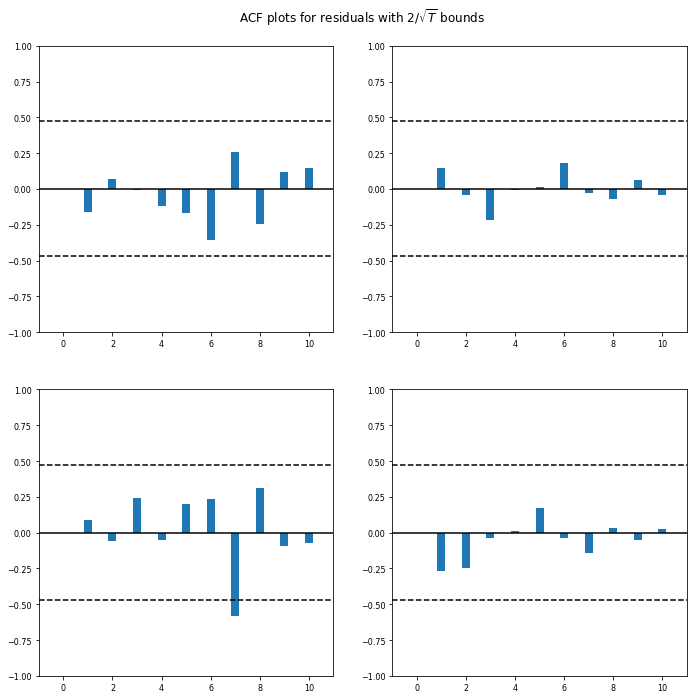

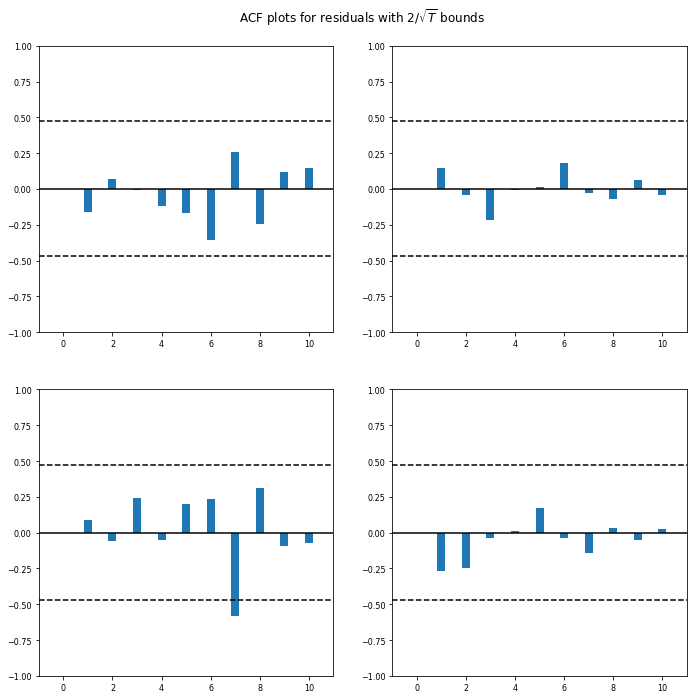

In [188]:
model_fitted.plot_acorr()

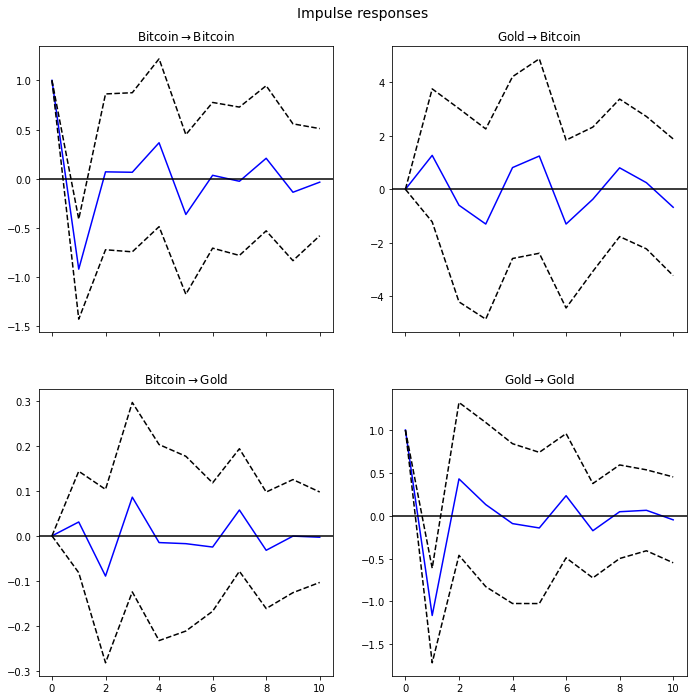

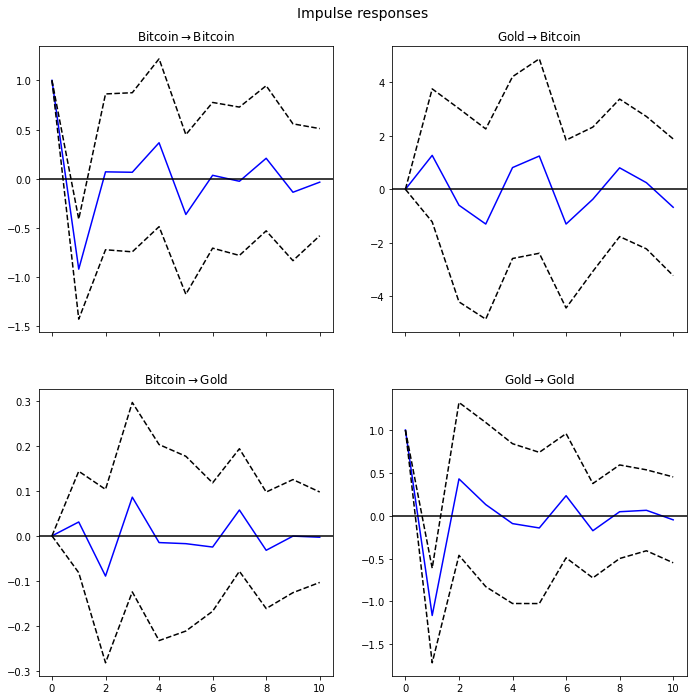

In [189]:
irf = model_fitted.irf(10)
irf.plot(orth=False)

In [190]:
model_fitted.info_criteria

{'aic': 6.904433471365983,
 'bic': 7.596944838618556,
 'hqic': 6.99992145105748,
 'fpe': 1086.6328004208256}

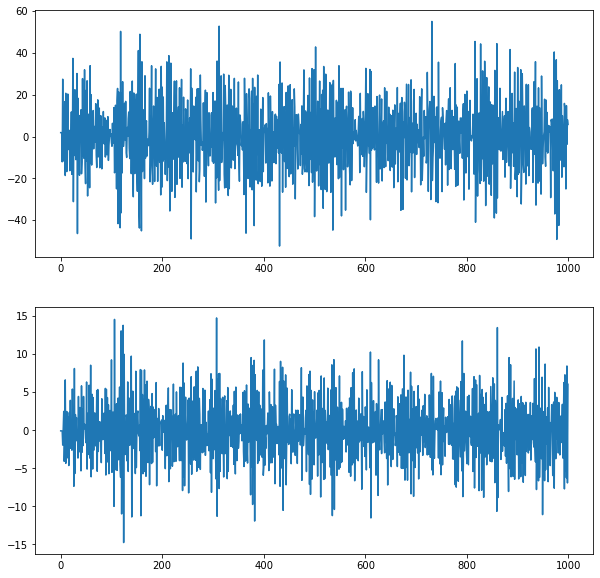

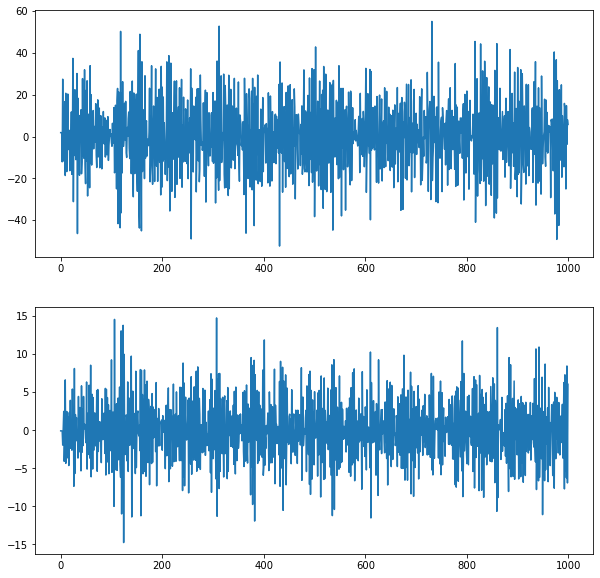

In [192]:
model_fitted.plotsim()

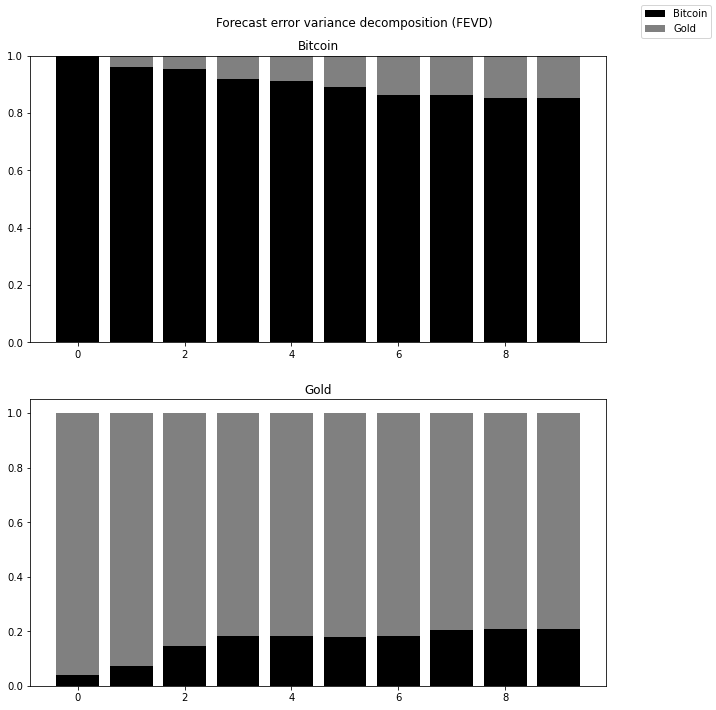

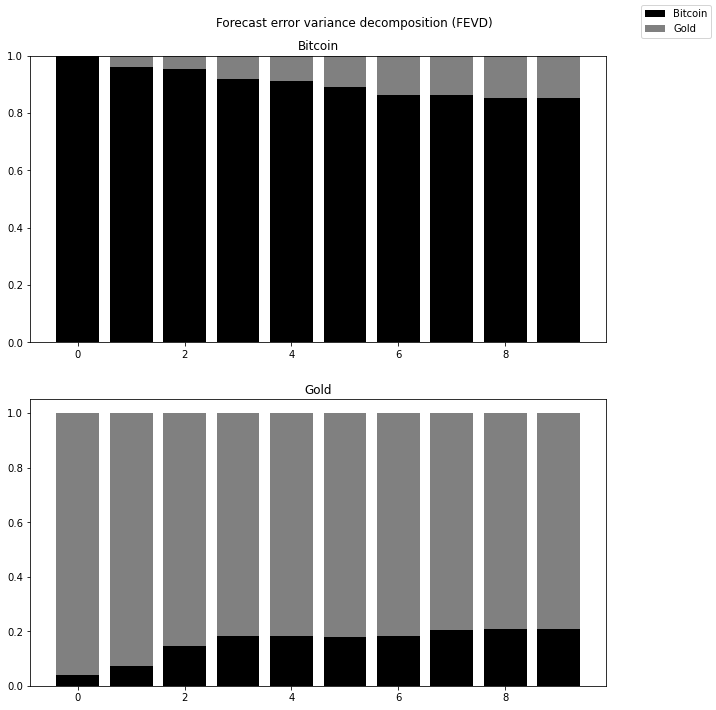

In [194]:
model_fitted.fevd(10).plot()

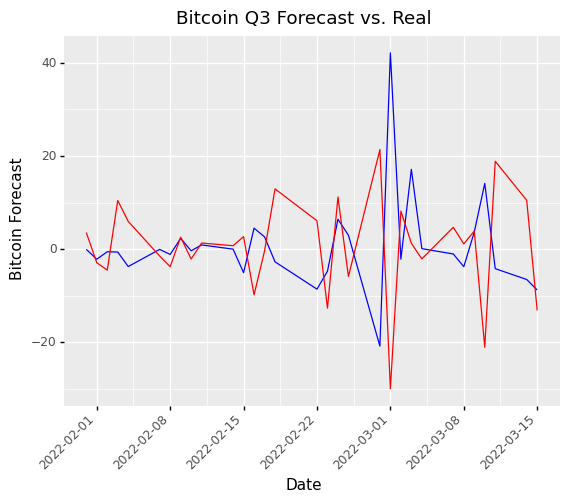

In [198]:
data_VAR_model = pd.concat([gold_returns['2022-01-30':'2022-03-15'].rename('Gold Returns'),
                                     bitcoin_returns['2022-01-30':'2022-03-15':].reindex(method="pad").rename('Bitcoin Returns'),
                            result_VAR2['Bitcoin Forecast'],result_VAR2['Gold Forecast']],axis=1, join="inner")
print(ggplot(data_VAR_model,aes(x='data_VAR_model.index')) + geom_line(aes(y='Bitcoin Forecast'),color='blue')
+ geom_line(aes(y='Bitcoin Returns'),color='red') + xlab('Date') + ggtitle('Bitcoin Q3 Forecast vs. Real')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

In [225]:
from statsmodels.tsa.statespace.varmax import VARMAX

nobs = 1
result_VARMA = pd.DataFrame()
window = 25

for index, values in pd.DataFrame(gold_returns).loc['2022-02-27':'2022-03-15'].iterrows():
  df_VARMA = pd.DataFrame(pd.concat([bitcoin_returns[index - pd.Timedelta(days=window):index],gold_returns[index - pd.Timedelta(days=window):index],equity_returns[index - pd.Timedelta(days=window):index]],axis=1).dropna())
  df_VARMA.columns = ['Bitcoin','Gold','Equity']
  model = VARMAX(df_VARMA[['Bitcoin', 'Gold','Equity']], order=(1,1))
  model_fitted = model.fit(maxiter=5, disp=False)
  forecast = model_fitted.forecast(1)
  df_forecast = pd.DataFrame(forecast)
  df_forecast.columns = ['Bitcoin Forecast','Gold Forecast','Equity Forecast']
  result_VARMA = pd.concat([result_VARMA,df_forecast])
    
result_VARMA.index = pd.DataFrame(gold_returns).loc['2022-02-27':'2022-03-15'].index
print(result_VARMA.head())


            Bitcoin Forecast  Gold Forecast  Equity Forecast
Date                                                        
2022-02-28         -9.170079       0.356794         3.056367
2022-03-01         33.861239      -0.575780         2.904753
2022-03-02          6.240778       3.337014        -2.512330
2022-03-03        -11.813350      -0.908199        -2.293785
2022-03-04          3.424814      -1.444411         1.045973


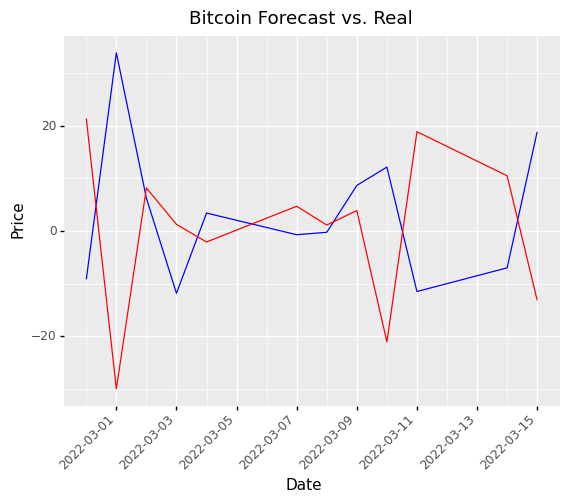

In [226]:
data_VARMAX = pd.concat([gold_returns['2022-02-27':'2022-03-15'].rename('Gold Returns'),
                                     bitcoin_returns['2022-02-27':'2022-03-15':].reindex(method="pad").rename('Bitcoin Returns'),
                            equity_returns['2022-02-27':'2022-03-15'].rename('Gold Returns'),
                            result_VARMA['Bitcoin Forecast'],result_VARMA['Gold Forecast'],result_VARMA['Equity Forecast']],axis=1, join="inner")
print(ggplot(data_VARMAX,aes(x='data_VARMAX.index')) + geom_line(aes(y='Bitcoin Forecast'),color='blue')  + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Bitcoin Returns'),color='red') + ggtitle('Bitcoin Forecast vs. Real ')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))


# VECM

In [237]:
result_VECM = pd.DataFrame()
for index, values in pd.DataFrame(gold_returns).loc['2022-02-27':'2022-03-15'].iterrows():
     vecm_data = pd.DataFrame(pd.concat([bitcoin_returns[index - pd.Timedelta(days=window):index].rename('Bitcoin Price'),gold_returns[index - pd.Timedelta(days=window):index].rename('Gold Price'),equity_returns[index - pd.Timedelta(days=window):index].rename('Equity Price')],axis=1).dropna())
     model = VECM(vecm_data, coint_rank=1)
     vecm_res = model.fit()
     forecast = vecm_res.predict(steps = 1)
     df_forecast = pd.DataFrame(forecast)
     df_forecast.columns = ['Equity Forecast','Gold Forecast','Bitcoin Forecast']
     result_VECM = pd.concat([result_VECM,df_forecast])
result_VECM.index = pd.DataFrame(gold_returns).loc['2022-02-27':'2022-03-15'].index
result_VECM.head()

,Equity Forecast,Gold Forecast,Bitcoin Forecast
Date,,,
2022-02-28,0.611986,-0.522247,-4.623614
2022-03-01,49.533845,-1.167278,3.117291
2022-03-02,-19.149099,4.648559,-4.748336
2022-03-03,-12.035276,1.154854,-3.778154
2022-03-04,3.999909,-4.312262,5.703121


# test_granger_causality

In [240]:
granger_results = vecm_res.test_granger_causality(caused='Bitcoin Price', signif=0.05)
print(granger_results.summary())

inst_caus_dp_r = vecm_res.test_inst_causality(causing="Bitcoin Price")
print(inst_caus_dp_r.summary())
inst_caus_r_dp = vecm_res.test_inst_causality(causing="Gold Price")
print(inst_caus_r_dp.summary())

norm_test = vecm_res.test_normality()
print(norm_test.summary())

white_test = vecm_res.test_whiteness(nlags=12, adjusted=True)
print(white_test.summary())

Granger causality F-test. H_0: ['Gold Price', 'Equity Price'] do not Granger-cause Bitcoin Price. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         5.464          3.056   0.006 (4, 15)
---------------------------------------------
Instantaneous causality Wald-test. H_0: Bitcoin Price does not instantaneously cause [Gold Price, Equity Price]. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         1.797          5.991   0.407  2
----------------------------------------
Instantaneous causality Wald-test. H_0: Gold Price does not instantaneously cause [Bitcoin Price, Equity Price]. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         4.827          5.991   0.089  2
----------------------------------------
n

In [ ]:
data_VECM_model_Q2_Q3 = pd.concat([price_gold_etf.Close['2020-07-01':'2020-09-30'].rename('Gold Price'),
                                     price_bitcoin['2020-07-01':'2020-09-30':].reindex(method="pad").rename('Bitcoin Price'),
                            result_Q3_VECM3['Bitcoin Forecast'],result_Q3_VECM3['Gold Forecast']],axis=1, join="inner")
print(ggplot(data_VECM_model_Q2_Q3,aes(x='data_VECM_model_Q2_Q3.index')) + geom_line(aes(y='Bitcoin Forecast'),color='blue') + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Bitcoin Price'),color='red') + ggtitle('Bitcoin Forecast vs. Real Q3')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

In [244]:
result_VECM

,Equity Forecast,Gold Forecast,Bitcoin Forecast
Date,,,
2022-02-28,0.611986,-0.522247,-4.623614
2022-03-01,49.533845,-1.167278,3.117291
2022-03-02,-19.149099,4.648559,-4.748336
2022-03-03,-12.035276,1.154854,-3.778154
2022-03-04,3.999909,-4.312262,5.703121
2022-03-07,0.110542,2.694885,-2.625790
2022-03-08,-3.051772,-1.589330,1.382044
2022-03-09,29.251893,5.669888,5.773270
2022-03-10,-8.698959,-3.359680,-1.630410


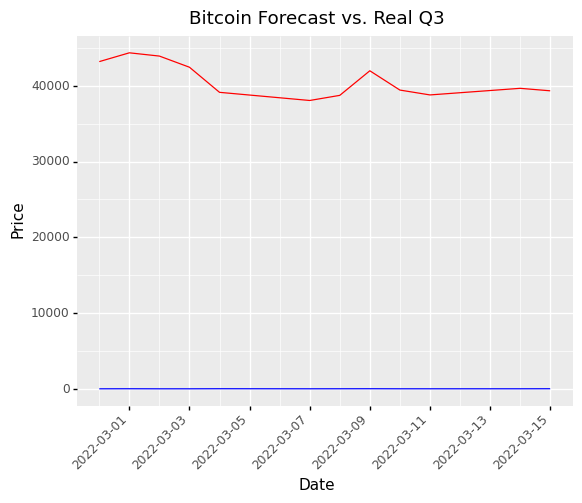

In [251]:
data_VECM_model = pd.concat([gold_etf.Close['2022-01-30':'2022-03-15'].rename('Gold Price'),
                                     bitcoin.Close['2022-01-30':'2022-03-15'].reindex(method="pad").rename('Bitcoin Price'),
                            result_VECM['Bitcoin Forecast'],result_VECM['Gold Forecast']],axis=1, join="inner")

print(ggplot(data_VECM_model,aes(x='data_VECM_model.index')) + geom_line(aes(y='Bitcoin Forecast'),color='blue') + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Bitcoin Price'),color='red') + ggtitle('Bitcoin Forecast vs. Real Q3')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

In [242]:
data_VECM_model = pd.concat([gold_etf['2022-01-30':'2022-03-15'].rename('Gold Price'),
                                     bitcoin['2022-01-30':'2022-03-15':].reindex(method="pad").rename('Bitcoin Price'),
                            result_VECM['Bitcoin Forecast'],result_VECM['Gold Forecast']],axis=1, join="inner")
print(ggplot(data_VECM_model,aes(x='data_VECM_model.index')) + geom_line(aes(y='Bitcoin Forecast'),color='blue') + xlab('Date') + ylab('Price')
+ geom_line(aes(y='Bitcoin Price'),color='red') + ggtitle('Bitcoin Forecast vs. Real Q3')
+ theme(axis_text_x=element_text(rotation=45, hjust=1)))

TypeError: 'str' object is not callable

# Johansen Cointegration Test

In [202]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
print('\nGold Bitcoin Equity  Johansen Cointegration Test')
gold_bitcoin_equity_coint_johansen = coint_johansen(pd.concat((equity_etf.loc['2021-06-30':'2022-03-15','Close'],gold_etf.reindex(equity_etf.index, method='pad').loc['2021-06-30':'2022-03-15','Close'],bitcoin.reindex(gold_etf.index, method='pad').loc['2021-06-30':'2022-03-15','Close']), axis=1).dropna(),det_order=0,k_ar_diff=4)
print('Maximum eigenvalue statistic:',gold_bitcoin_equity_coint_johansen.lr2)
print('Critical values (90%, 95%, 99%) of maximum eigenvalue statistic.\n',gold_bitcoin_equity_coint_johansen.cvm)
print('Trace statistic',gold_bitcoin_equity_coint_johansen.lr1)
print('Critical values (90%, 95%, 99%) of trace statistic\n',gold_bitcoin_equity_coint_johansen.cvt)


Gold Bitcoin Equity  Johansen Cointegration Test


ValueError: cannot reindex a non-unique index with a method or limit